![Sizing Lab](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/Baniere.png)

# Hydrid Storage Architecture and Specification 

*Written by Marc Budinger, INSA Toulouse, France*

We will consider here an hybrid solutions with super capacities and traction battery packs. This notebook is dedicated :
- to understand main operating limits of super capacitors and batteries
- to understand a control architecture enabling to split power between super capacitors and batteries  
- to specify energy storage requirements of the different energy sources.

The storage element selection approach developed here is inspired by the following publication:
> Jaafar, A., Sareni, B., Roboam, X., & Thiounn-Guermeur, M. (2010, September). Sizing of a hybrid locomotive based on accumulators and ultracapacitors. In 2010 IEEE Vehicle Power and Propulsion Conference (pp. 1-6). IEEE.[[pdf](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/papers/Sizing_of_a_hybrid_locomotive_based_on_accumulators_and_ultracapacitors.pdf)]

### Main operating limits of energy storage components

To enable the selection of energy storage means, it is necessary to understand their main operational limitations. These limits can be representative:
- **rapid deterioration** that can develop over an operating cycle, for example one journey or a few journeys over the same day.  
- **gradual degradation** linked to the lifespan of the component over multiple cycles, months or years, where the accumulation of degradation leads to an irreversible loss of performance.  

> **Questions:** Examine the following Figures extract from datasheet of elementary storage cells of [supercapacitors](https://1188159.fs1.hubspotusercontent-na1.net/hubfs/1188159/02-DS-220909-SKELCAP-CELLS-1F.pdf) or [battery (LiFeSO4)](https://5.imimg.com/data5/SELLER/Doc/2021/3/VO/ZR/QG/86781150/3-2-v-10-ah-lifepo4-prismatic-cell.pdf). Propose selection criteria representative of the main operational limits. Explain how to size a battery taking into account an high number of [discharge cycles](https://www.powertechsystems.eu/home/tech-corner/lithium-iron-phosphate-lifepo4/).

![Battery Cell](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/BatteryCellEXample.png)

![Ultracapacitor Cell](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/SCCellExample.png)


### Simulation of a complete line

The objective of this section is to propose an evolution of the previous python codes to be able to:
- simulate the power profile necessary for a complete line comprising several sections.
> - *We will define in particular the type of vehicle, the different lengths of sections between 2 stations (Distances vector), the average speed to be ensured (Speeds vector), the presence of charger in station (Chargers vector), the stopping duration at station (StopDuration vector), the ratio between the maximum braking power and the maximum acceleration power (RatioBrakeMax).*
- provide the information necessary for sizing the battery/supercapacity packs that could be added.
> - *We assume here an efficiency of the motorization chain of 100%.*
> - *Each line section will be optimized in order to meet the requirements defined previously and minimize the energy consumed.*
> -*The energy flow or the resulting power demand will be shared between battery and supercapacity with control based on frequency sharing of demands: the low frequency power will be provided by the batteries while the high frequency part will be provided by supercapacitors.*
> - *Indicators useful for sizing will then be generated from these power profiles.*

- take into account the energy that could come from charging stations or catenaries.
> - *This version will only implement the consideration of charging stations.*
> - *Each charging station will provide the power to compensate for the energy of the travel from the last station.*


Here we load all the functions and classes defined in the previous notebook.

Consumption per passenger: 14.35 kJ/(Pax.km)


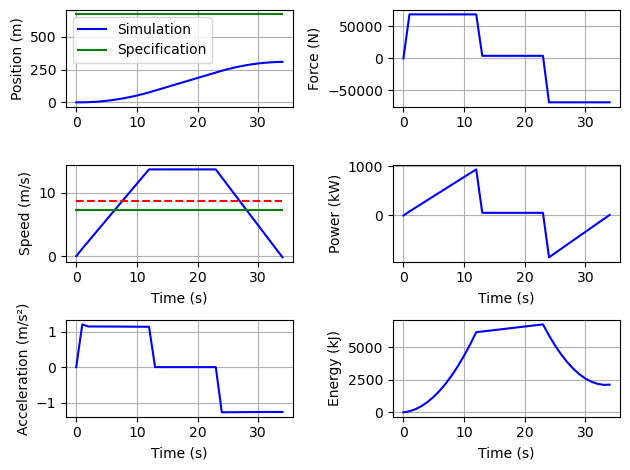

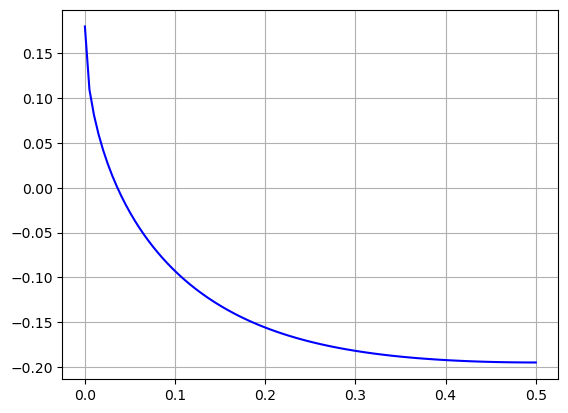

[0.036125972011676784, 1, 0.9638740279883232]
Consumption per passenger: 20.44 kJ/(Pax.km)


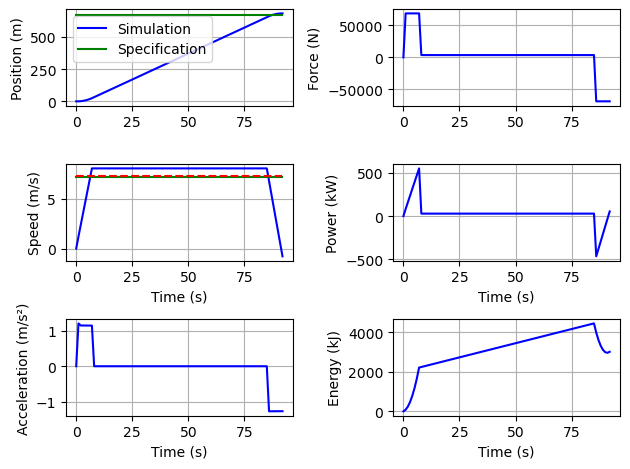

     fun: 1.1159001242362934
 message: 'Optimization terminated successfully.'
    nfev: 1039
     nit: 22
 success: True
       x: array([0.14682836, 0.35571372, 0.98903859])
Optimal vector : [0.14682836 0.35571372 0.98903859]
0.5705464574206788
Constraints vector : [0.00850395447235165, 0.00020729684908794098, 0.0294535425793212]
Consumption per passenger: 17.18 kJ/(Pax.km)


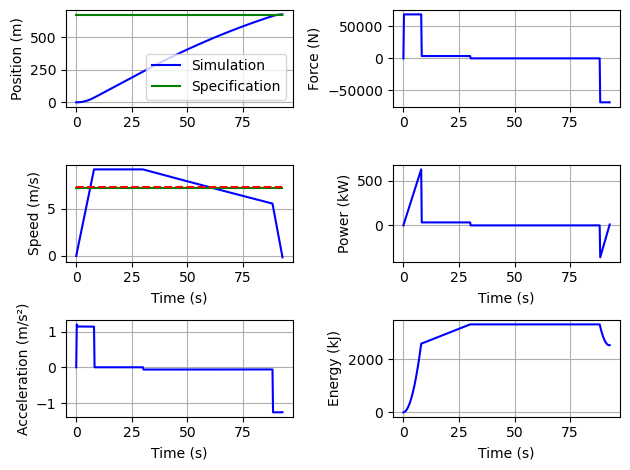

Calculation of energy consumption of different vehicles: 

Tramway :
     fun: 1.3155835512285257
 message: 'Optimization terminated successfully.'
    nfev: 1264
     nit: 27
 success: True
       x: array([0.29399515, 0.1861679 , 0.98988572])
Consumption per passenger: 20.59 kJ/(Pax.km)
----
Trolleybus :
     fun: 1.1340254283077316
 message: 'Optimization terminated successfully.'
    nfev: 1534
     nit: 33
 success: True
       x: array([0.05336668, 0.76280189, 0.98802964])
Consumption per passenger: 33.90 kJ/(Pax.km)
----
Bus :
     fun: 1.1554437831959297
 message: 'Optimization terminated successfully.'
    nfev: 1309
     nit: 28
 success: True
       x: array([0.05242056, 0.76276309, 0.98817021])
Consumption per passenger: 35.30 kJ/(Pax.km)
----
Car :
     fun: 1.522255018926166
 message: 'Optimization terminated successfully.'
    nfev: 2119
     nit: 46
 success: True
       x: array([2.43633712e-04, 9.96635980e-01, 9.83979268e-01])
Consumption per passenger: 102.08 kJ/(Pax

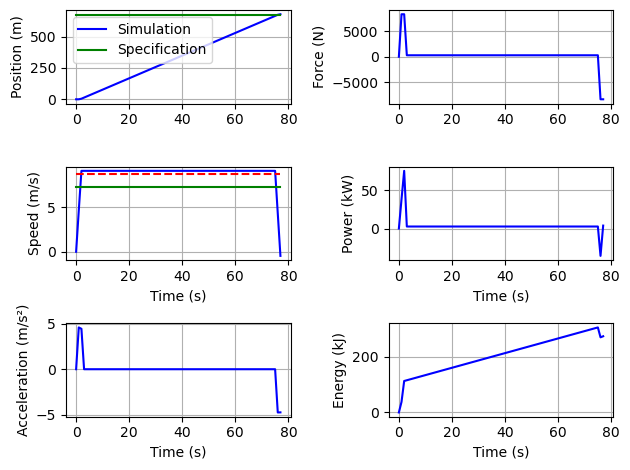

In [1]:
%run ./01b_CaseStudy_Specification.ipynb

Here we define a `line` class with all the functionalities described just before.

In [2]:

from scipy import signal

class line():
    def __init__(self,Vehicle, Distances,Speeds, Chargers, StopDuration, RatioBrakeMax):
        i=0
        self.Section=[]
        self.Chargers =  Chargers # Boolean vector (True = Charger, False = No Charger , at end of te section)
        self.StopDuration = StopDuration # [s] station stop duration (scalar)
        self.RatioBrakeMax = RatioBrakeMax # [-] Ratio between max braking power / max acceleration power
        
        # initialization of  transient evolution (vectors)
        self.PowerStorage= [] # Transient evolution of requested power
        self.GlobalTime=[] # Time vector for plot and energy integration
        self.GlobalNRJStorage=[] # Transient evolution of energy
        self.PowerLF = [] # Transient evolution of power  (Low Frequency)
        self.PowerHF = [] # Transient evolution of power  (high Frequency)
        self.LFNRJStorage=[] # Time vector for plot and energy integration (Low Frequency)
        self.HFNRJStorage=[] # Time vector for plot and energy integration (High Frequency)

        self.TotalLineDistance =  sum(Distances)
        self.dt=0.25 # Time step for numerical integration
        
        # print characteristic of each section
        for d,s,c in zip(Distances,Speeds,Chargers):
            print("Section %.i: %.i m at %.2f m/s %s charger"%(i+1,d,s, "whith" if c else "without"))
            self.Section=self.Section+[OptimSection(Vehicle,d,s,self.RatioBrakeMax,self.dt)]
            i=i+1
    
    # Optimization loop of each section of the line
    def optimLine(self):
        X=[0.1,1,0.9]
        for i in range(len(self.Section)):
            self.Section[i].optimizeG(X)
            self.Section[i].plot()   
    
    # Power vector concatenation 
    def CalculPowerStorage(self):
        NRJ = 0
        self.PowerStorage= []
        self.GlobalTime= []
        dt=self.dt # [s] pas de temps pour l'integration
        
        # Power vector build thanks concatenation 
        for i in range(len(self.Section)):
            print(i)
            NRJ=NRJ+self.Section[i].NRJsection[-1] # we add here the energy consummed on the section
            
            self.PowerStorage = self.PowerStorage + self.Section[i].psection
            
            # Chargers effect
            if (self.Chargers[i] == True and i<(len(self.Section)-1)):
                tcharge=NRJ/self.Section[i].Vehicle.Pmax # Charging time caculation function of energy  
            else:
                tcharge=0
            if (tcharge>=self.StopDuration):
                self.PowerStorage = self.PowerStorage + [-self.Section[i].Vehicle.Pmax]*int(tcharge/dt)
                NRJ=0
            else:
                if (i<(len(self.Section)-1)):
                    self.PowerStorage = self.PowerStorage + [-self.Section[i].Vehicle.Pmax]*int(tcharge/dt)
                    self.PowerStorage = self.PowerStorage + [0]*int((self.StopDuration-tcharge)/dt)
                if (self.Chargers[i] == True) :
                    NRJ=0  
        
        # Time vector
        t=0
        for i in range(len(self.PowerStorage)):
            self.GlobalTime = self.GlobalTime + [t]
            t = t + dt
            
    # Filtering of total power in order to generate LF and HF pwoers
    def FilterPower(self, omega):
        TF=signal.TransferFunction([1], [1/omega**2, 2*1/omega, 1])
        time, self.PowerLF, state = signal.lsim(TF, self.PowerStorage , self.GlobalTime)
        self.PowerHF = self.PowerStorage -  self.PowerLF
        
    # NRJ vector integration from power vectors
    def IntegrateNRJ(self):
        t=0
        NRJtotal=0
        NRJHF=0
        NRJLF=0
        #NRJTotalAging=0
        #NRJLFAging=0
        self.HFNRJStorage = []
        self.GlobalNRJStorage = []
        self.LFNRJStorage = []
        dt=self.dt
        
        for i in range(len(self.PowerStorage)):
            self.GlobalNRJStorage = self.GlobalNRJStorage + [NRJtotal]
            self.HFNRJStorage = self.HFNRJStorage + [NRJHF]
            self.LFNRJStorage = self.LFNRJStorage + [NRJLF]
            #self.TotalNRJAging = self.TotalNRJAging + [NRJTotalAging]
            #self.LFNRJAging = self.LFNRJAging + [NRJLFAging]
        
            t = t + dt
            NRJtotal = NRJtotal+(self.PowerStorage[i])*dt
            NRJHF = NRJHF+(self.PowerHF[i])*dt
            NRJLF = NRJLF+(self.PowerLF[i])*dt
        
        PmaxHF = max(abs(min(self.PowerHF)),max(self.PowerHF))/1e3 # kW
        PmaxLF = max(self.PowerLF)/1e3 # kW 
        PmaxBrakeLF = abs(min(self.PowerLF))/1e3 # kW, Max power braking
        NRJHF = (max(self.HFNRJStorage) - min(self.HFNRJStorage))/3600/1e3 # NRJ en kWh
        NRJLF = (max(self.LFNRJStorage) - min(self.LFNRJStorage))/3600/1e3 # NRJ en kWh
        
        return PmaxHF, PmaxLF, PmaxBrakeLF, NRJHF, NRJLF
          
    
    
                
    # Main results plot
    def plot(self):
        fig, axs = plt.subplots(2,1)
        axs[0].plot(self.GlobalTime,self.PowerStorage,'b-',label='Total')
        axs[0].plot(self.GlobalTime,self.PowerLF,'r-.',label='LF')
        axs[0].plot(self.GlobalTime,self.PowerHF,'g-.',label='HF')
        axs[0].set_ylabel("Power (W)")
        axs[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        axs[0].grid()
        axs[1].plot(self.GlobalTime,self.GlobalNRJStorage,'b-',label='Total')
        axs[1].plot(self.GlobalTime,self.LFNRJStorage,'r-.',label='LF')
        axs[1].plot(self.GlobalTime,self.HFNRJStorage,'g-.',label='HF')
        axs[1].set_ylabel("Energy (J)")
        axs[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        axs[1].grid()
              
        axs[1].set_xlabel('Time (s)') 
        
        fig.tight_layout()            
        
        
            

### Example of a line definition

We can now use this new class to define a bus transport line with the following requirements:
- distances: 700, 500, 400, 700, 3000, 300, 300, 300, 300, 300 m/s
- mean speed: 7, 7, 7, 5, 5, 5, 5, 5 m/s
- one final charger


In [3]:
ToulouseC=line(Bus,[700,500,400,700,300,300,300,300,300],[7, 7, 7,5,5,5,5,5],[False,False,False,False,False,False,False,True], 20, 0.6)
#ToulouseC=line(Bus,[700,500,400],[7, 7, 7],[False,False,True], 20, 0.6)


Section 1: 700 m at 7.00 m/s without charger
Section 2: 500 m at 7.00 m/s without charger
Section 3: 400 m at 7.00 m/s without charger
Section 4: 700 m at 5.00 m/s without charger
Section 5: 300 m at 5.00 m/s without charger
Section 6: 300 m at 5.00 m/s without charger
Section 7: 300 m at 5.00 m/s without charger
Section 8: 300 m at 5.00 m/s whith charger


Each speed profil section can be optimized.

     fun: 1.0802796716463516
 message: 'Optimization terminated successfully.'
    nfev: 1444
     nit: 31
 success: True
       x: array([0.051935  , 0.79255724, 0.98939297])
     fun: 1.094597172378344
 message: 'Optimization terminated successfully.'
    nfev: 1039
     nit: 22
 success: True
       x: array([0.09605835, 0.6919144 , 0.98337341])
     fun: 1.1043612789972144
 message: 'Optimization terminated successfully.'
    nfev: 1444
     nit: 31
 success: True
       x: array([0.14074893, 0.6151798 , 0.97024822])
     fun: 1.0581311128951516
 message: 'Optimization terminated successfully.'
    nfev: 2029
     nit: 44
 success: True
       x: array([0.02774038, 0.88916294, 0.98990994])
     fun: 1.0639068253503727
 message: 'Optimization terminated successfully.'
    nfev: 1219
     nit: 26
 success: True
       x: array([0.06395323, 0.74263962, 0.98849925])
     fun: 1.0640024166257454
 message: 'Optimization terminated successfully.'
    nfev: 1084
     nit: 23
 success: True

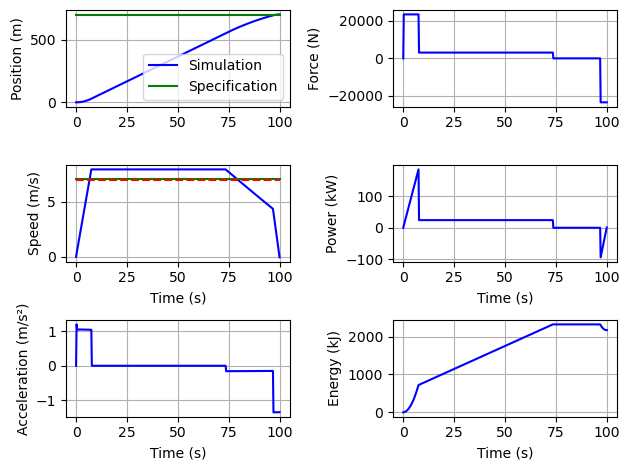

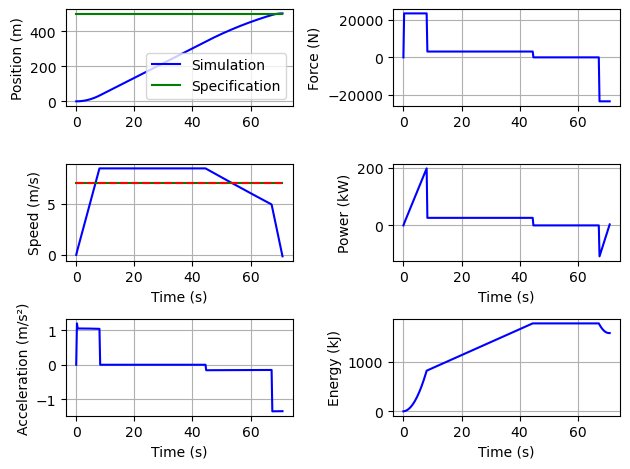

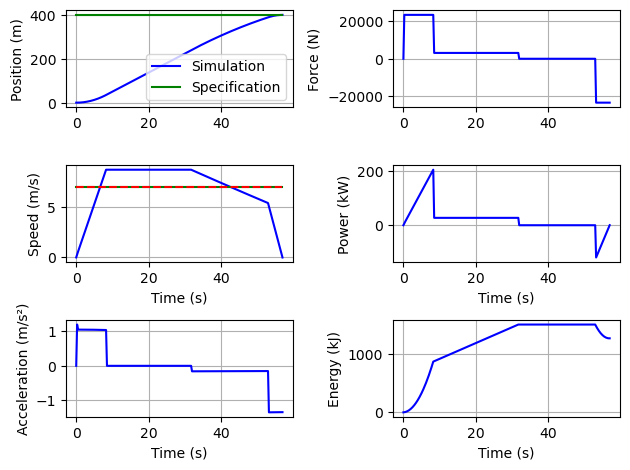

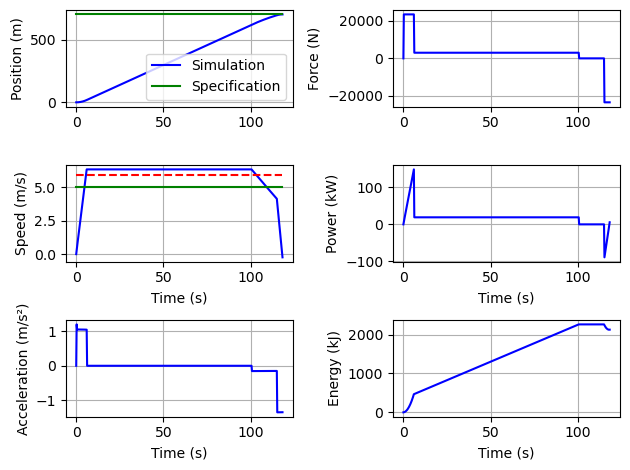

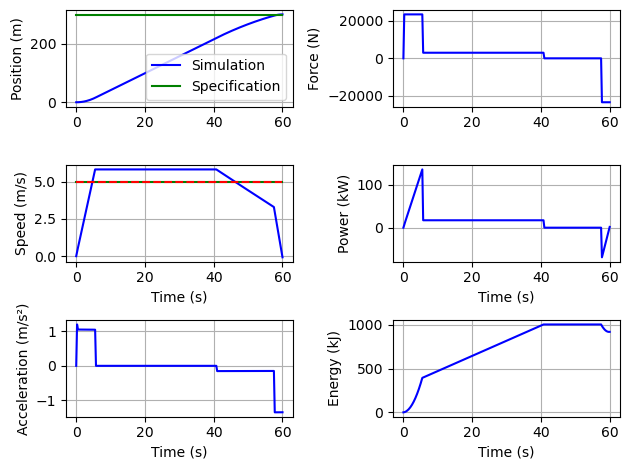

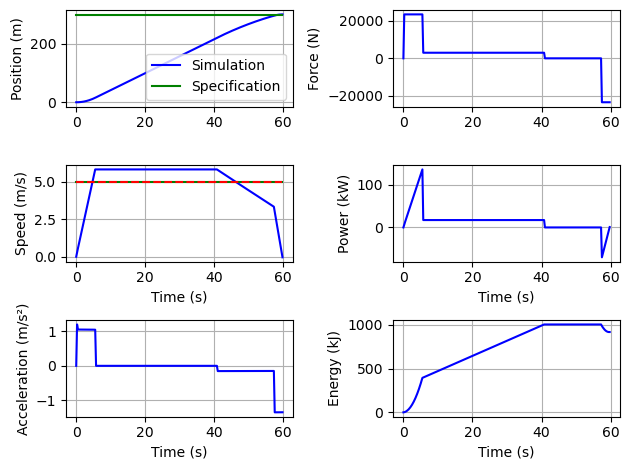

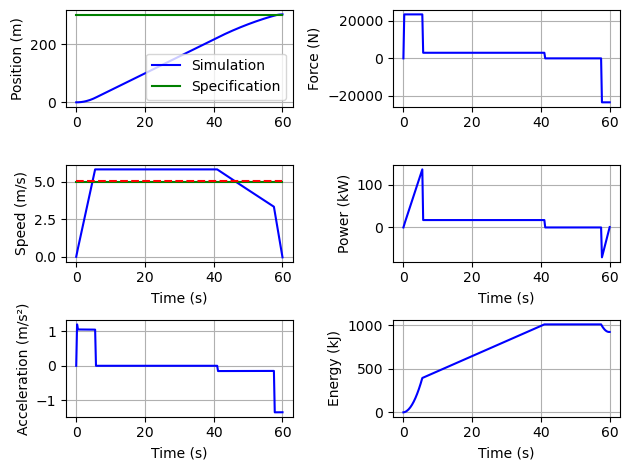

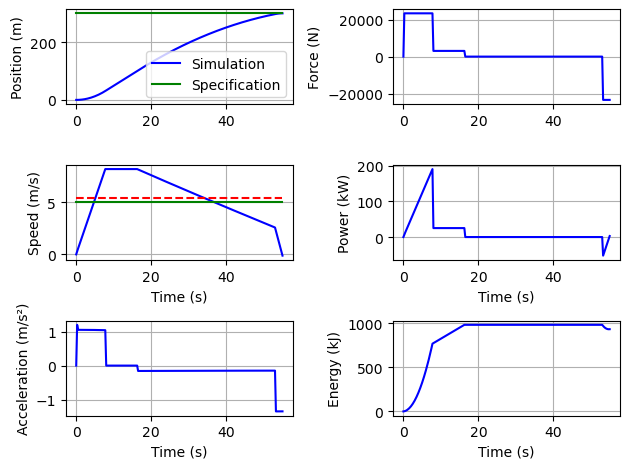

In [8]:
ToulouseC.optimLine()

A time vector of evolution of the power required at each section or supplied to each charger is constructed.

In [14]:
ToulouseC.CalculPowerStorage()

0
1
2
3
4
5
6
7


### Hybrid storage system sizing

The energy flow or the resulting power demand will be shared between battery and supercapacity with control based on frequency sharing of demands. The Figure below show how the low frequency power will be provided by the batteries while the high frequency part will be provided by supercapacitors.

![Sizing Stategy](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/EnergyManagment.png)

The cutoff frequency defines the power sharing and has a strong influence on the sizing of the storage elements. The following code analyzes this power sharing by varying this cutoff frequency.

> Questions: Explain the sizing criteria implemented here to evaluate the mass or CO2 impact of batteries and supercapacitors.

In [10]:
omegaV=np.logspace(-5,2,50)
MassStorageV=[]
MassSC=[]
MassLFPAging=[]
MassLFPNRJ=[]
MassLFPPow=[]
CO2Total=[]

# Hypothese
Targetkm = 250e3 # [km] durée de vie du vehicule

# Energie massique des supercapacités
# https://1188159.fs1.hubspotusercontent-na1.net/hubfs/1188159/02-DS-220909-SKELCAP-CELLS-1F.pdf
# chez Skeleton
WmassSC=6.8*0.75 # [Wh/kg] on suppose pouvoir recuperer 75% de l'energie stockée
PmassSC=860/4.3*6.8*0.75 # [W/kg]

# Energie massique des batteries
# LFP
WmassLFP= 100 # [Wh/kg] les LFP peuvent pratiquement etre dechargé a 100%
PmassLFP=3*100 # [W/kg]  puissance massique en decharge à 3 C
PBmassLFP=1*100 # [W/kg]  puissance massique en decharge à 1 C
Ncycle = 3000 # [-] nb de cycle de decharge a 100%

# Bilan carbone
CO2SC = 39 # kgCO2eq/kg d'ecoInvent
CO2LFP = 11 # kgCO2eq/kg d'ecoInvent

for omega in omegaV:
    ToulouseC.FilterPower(omega)
    PmaxHF, PmaxLF, PmaxBrake, NRJHF, NRJLF = ToulouseC.IntegrateNRJ()
    
    Nc=Targetkm*1000/ToulouseC.TotalLineDistance # Number of cycles for global lifetime 
    DoD=(Nc/3365)**(-1/2.26) # DoD calculation for Target Km
    MassStorageV = MassStorageV + [max(NRJHF/WmassSC*1e3, PmaxHF/PmassSC*1e3)
                                   +max(NRJLF/DoD/WmassLFP*1e3,
                                       PmaxLF/PmassLFP*1e3, PmaxBrake/PBmassLFP*1e3)] 
    MassSC = MassSC + [max(NRJHF/WmassSC*1e3, PmaxHF/PmassSC*1e3)] 
    MassLFPNRJ = MassLFPNRJ + [NRJLF/WmassLFP*1e3] 
    
    MassLFPAging = MassLFPAging + [NRJLF/DoD/WmassLFP*1e3] 
    MassLFPPow = MassLFPPow + [PmaxBrake/PBmassLFP*1e3]
    CO2Total = CO2Total + [max(NRJHF/WmassSC*1e3, PmaxHF/PmassSC*1e3)*CO2SC+
                           max(NRJLF/DoD/WmassLFP*1e3, PmaxLF/PmassLFP*1e3, PmaxBrake/PBmassLFP*1e3)*CO2LFP]


The following figures represent the overall mass of the solutions according to the power sharing achieved. A simple CO2 impact is also estimated.

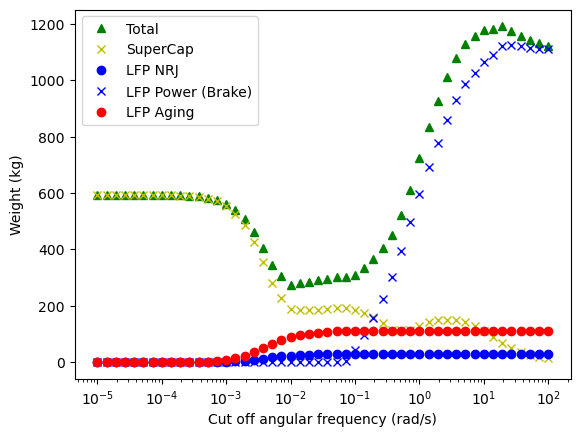

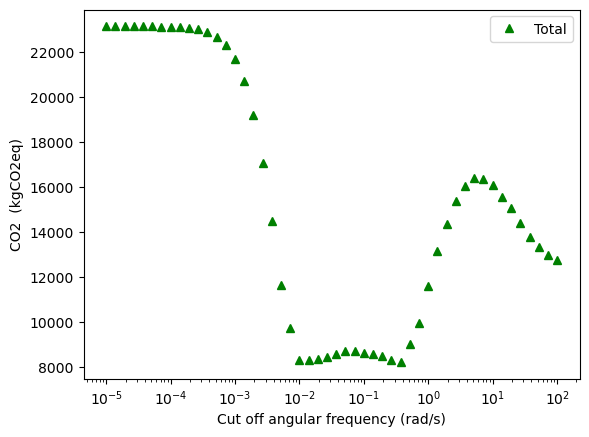

In [11]:

plt.plot(omegaV, MassStorageV, 'g^', label='Total')
plt.plot(omegaV, MassSC, 'yx', label='SuperCap')
plt.plot(omegaV, MassLFPNRJ, 'bo', label='LFP NRJ')
plt.plot(omegaV, MassLFPPow, 'bx', label='LFP Power (Brake)')
plt.plot(omegaV, MassLFPAging, 'ro', label='LFP Aging')
plt.xscale('log') 
plt.ylabel('Weight (kg)')
plt.xlabel('Cut off angular frequency (rad/s)')
plt.legend()
plt.show()
plt.plot(omegaV, CO2Total, 'g^', label='Total')
plt.xscale('log') 
plt.ylabel('CO2  (kgCO2eq)')
plt.xlabel('Cut off angular frequency (rad/s)')
plt.legend()
plt.show()

A [Pareto front](https://en.wikipedia.org/wiki/Pareto_front) can help find a solution achieving a compromise between 2 objectives.

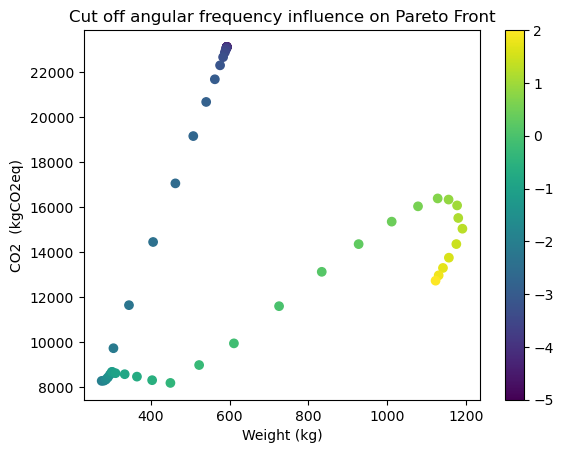

In [12]:
# Pareto Front

plt.scatter(MassStorageV, CO2Total, c=np.log10(omegaV))
plt.xlabel('Weight (kg)')
plt.ylabel('CO2  (kgCO2eq)')
plt.colorbar()
plt.title('Cut off angular frequency influence on Pareto Front')
plt.show()

Super Capacitor:
Pmax: 118.02 kW
NRJ:  0.22 kWh
Mass:  115.7 kg
---
Traction battery:
Pmax discharge: 105.01 kW
Pmax charge: 32.22 kW
NRJ: 11.27 kWh
NRJ one travel: 3.02 kWh
Mass:  350.0 kg
Mass (brake criteria):  350.0 kg
---


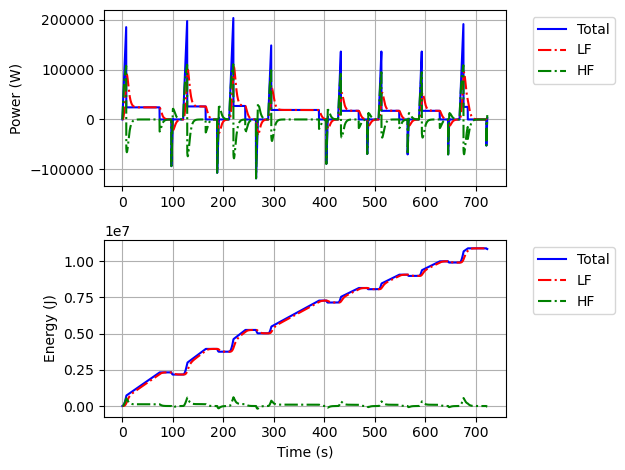

In [15]:
ToulouseC.FilterPower(0.4)
PmaxHF, PmaxLF, PmaxBrakeLF, NRJHF, NRJLF=ToulouseC.IntegrateNRJ()

Nc=Targetkm*1000/ToulouseC.TotalLineDistance # Number of cycles for global lifetime 
DoD=(Nc/3365)**(-1/2.26) # DoD calculation for Target Km

print("Super Capacitor:")
print("Pmax: %.2f kW"%PmaxHF)
print("NRJ:  %.2f kWh"%NRJHF)
print("Mass: % .1f kg"%(max(NRJHF/WmassSC*1e3, PmaxHF/PmassSC*1e3)))
      
print("---")
print("Traction battery:")
print("Pmax discharge: %.2f kW"%PmaxLF)
print("Pmax charge: %.2f kW"%PmaxBrakeLF)
print("NRJ: %.2f kWh"%(NRJLF/DoD))
print("NRJ one travel: %.2f kWh"%(NRJLF))
print("Mass: % .1f kg"%(max(NRJLF/DoD/WmassLFP*1e3,
                                       PmaxLF/PmassLFP*1e3, PmaxBrakeLF/PBmassLFP*1e3)))  
print("Mass (brake criteria): % .1f kg"%(PmaxLF/PmassLFP*1e3))  


ToulouseC.plot()
print("---")

### Labwork and homework

Your objective is to specify the hybrid storage system of an electric bus for doubling line 78 between the IUT Rangueil and MFJA stations.
The characteristics of the bus are [here](https://www.bluebus.fr/bluebus-6-metres)  
![BlueBus](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/bluebus.png)
A example of time table of the line 78 is [here](https://www.tisseo.fr/sites/default/files/fh/ligne78.html)  
![L78](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/L78.PNG)
We will assume a round trip in 20 min, charge at the ends of the lines included.  

> Modify the present notebooks in order to set up a technical justification report : starting from the need (journey, vehicle size, frequency of journeys), setting up the effort/speed/power profiles, the power distribution in the hybrid storage system, the preliminary sizing and the specification of the main components.  

> Adapt and complete the sizing process in order to take into account the global efficiency of the converters and storage elments (assumed to be equal to 80%).   

![Sizing process](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/SizingProcessNu.PNG)  

> Propose compatible technological [storage packs](https://www.skeletontech.com/en/supercapacitor-modules) and specify the DC/DC converters (DC bus of 400 V). 

> Provide an electrical architecture diagram ([possible software](https://qelectrotech.org/)) summarizing your main choices:
>- representing the different sources and load of the network.  
>- making it possible to standardize the DC/DC converters used.  
>- allowing reduced functionality to be maintained in the event of a fault on part of the storage elements  



